# CIFAR-10 Image Recognition

Image recognition task can be efficiently completed with Convolutional Neural Network (CNN). In this notebook, we showcase the implementation of CNN with PyTorch, as well as data preprocessing and regularisation techniques used to improve its accuracy.

## Preliminary work

Importing packages.

In [ ]:
# pip install torch torchvision numpy matplotlib
import torch
import torchvision
from torch import nn
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

We load dataset without transformations. Dataloaders are also defined to visualise the image and used in training and testing.

In [ ]:
# Train transformation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Shape of X [N, C, H, W]:  torch.Size([256, 3, 32, 32])
Shape of y:  torch.Size([256]) torch.int64


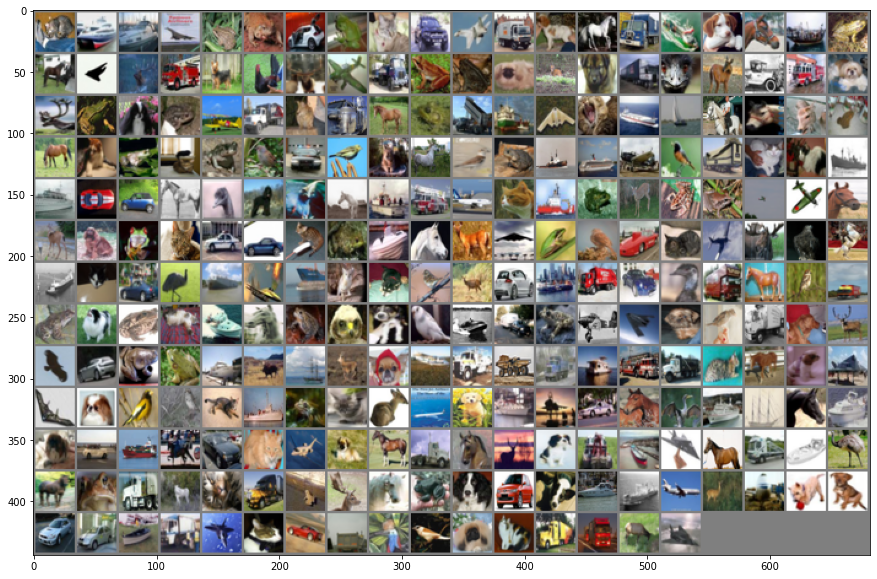

In [ ]:
# Training batch size
batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Each batch tensor shape
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    
    imshow(torchvision.utils.make_grid(X, nrow=20))
    
    break

Training and testing functions are defined here. They will be used in the neural network.

In [ ]:
# Training function
def train(dataloader, model, loss_fn, optimizer, acc, losslog):
    size = len(dataloader.dataset)
    
    # Turn on training mode
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= len(dataloader)
    correct /= size

    acc.append(correct)
    losslog.append(train_loss)
    
    #print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")

In [ ]:
# Test function
def test(dataloader, model, loss_fn, acc, losslog):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Turn on evalution mode
    model.eval()
    test_loss, correct = 0, 0
    
    # Turn off gradient descent
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # record loss
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size

    acc.append(correct)
    losslog.append(test_loss)

    #print(f" Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

## Linear Network

A neural network with 3 linear layers is defined.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


We train with naive stochastic gradient descent (SGD) using cross entropy loss (CE) and weight decay.

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)

Done! Max accuracy = 0.5538


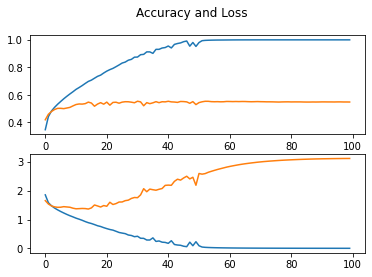

In [ ]:
# Total training epochs
epochs = 100
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for t in range(epochs):
    #print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(train_dataloader, model, loss_fn, optimizer, train_acc, train_loss)
    test(test_dataloader, model, loss_fn, test_acc, test_loss)
    
print(f"Done! Max accuracy = {max(test_acc)}")
fig, axs = plt.subplots(2)
fig.suptitle('Accuracy and Loss')
axs[0].plot(train_acc)
axs[0].plot(test_acc)
axs[1].plot(train_loss)
axs[1].plot(test_loss)

Although the network trains fast, its shallow depth underfits the dataset, thus achieving a low accuracy. We can turn to CNN to address this issue in the next part.

## Shallow CNN

A neural network with 3 convolutional layers is defined.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(), 
            nn.Linear(32*32*32, 10)) 
            # 64 = channel, 32*32 = dimension, 10 = output class
        
    def forward(self, x):
        return self.network(x)

convmodel = ConvNeuralNetwork().to(device)

print(convmodel)

Using cuda device
ConvNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=32768, out_features=10, bias=True)
  )
)


We train with naive SGD using CE loss and weight decay.

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(convmodel.parameters(), lr=1e-1, weight_decay=1e-4)

Done! Max accuracy = 0.6787


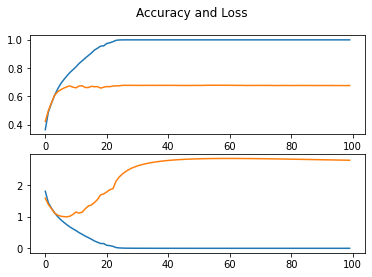

In [ ]:
# Total training epochs
epochs = 100
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for t in range(epochs):
    #print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(train_dataloader, convmodel, loss_fn, optimizer, train_acc, train_loss)
    test(test_dataloader, convmodel, loss_fn, test_acc, test_loss)
    
print(f"Done! Max accuracy = {max(test_acc)}")
fig, axs = plt.subplots(2)
fig.suptitle('Accuracy and Loss')
axs[0].plot(train_acc)
axs[0].plot(test_acc)
axs[1].plot(train_loss)
axs[1].plot(test_loss)

The large discrepancy between train accuracy and test accuracy suggests overfitting. We will adopt various regularisation techniques to address this issue in the next part.

## Shallow CNN with regularisations

We load the dataset again, but with transformations such as cropping and flipping to augment the data, thus adding more training data and improving the generalisation capability of the network.

In [ ]:
# Train transformation
train_transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
# Download training data from open datasets.
transformed_training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets.
transformed_test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 256

# Create data loaders.
transformed_train_dataloader = DataLoader(transformed_training_data, batch_size=batch_size)
transformed_test_dataloader = DataLoader(transformed_test_data, batch_size=batch_size)

We train with SGD using CE loss and weight decay. Momentum is also added to SGD to prevent stucking at local minimum.

Done! Max accuracy = 0.7635


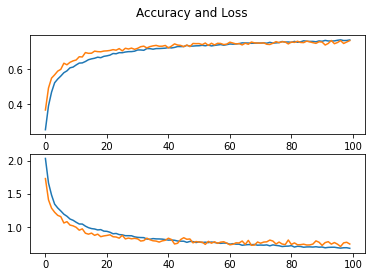

In [ ]:
convmodel3 = ConvNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convmodel3.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
epochs = 100
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for t in range(epochs):
    #print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(transformed_train_dataloader, convmodel3, loss_fn, optimizer, train_acc, train_loss)
    test(transformed_test_dataloader, convmodel3, loss_fn, test_acc, test_loss)
    
print(f"Done! Max accuracy = {max(test_acc)}")
fig, axs = plt.subplots(2)
fig.suptitle('Accuracy and Loss')
axs[0].plot(train_acc)
axs[0].plot(test_acc)
axs[1].plot(train_loss)
axs[1].plot(test_loss)

# Deep CNN with regularisations

Regularisation techniques on the model level, namely dropout and batch Normalisation layers, was adopted to improve model performance. The depth of model is also increased.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DeepConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout2d(p=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout2d(p=0.4),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.network(x)

deepconvmodel = DeepConvModel().to(device)

print(deepconvmodel)

Using cuda device
DeepConvModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

Done! Max accuracy = 0.9123


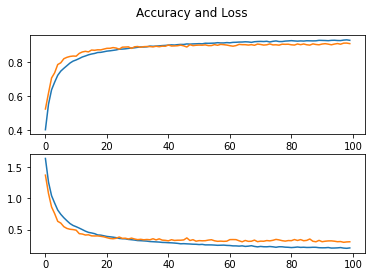

In [ ]:
optimizer = torch.optim.SGD(deepconvmodel.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 100
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for t in range(epochs):
    #print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(transformed_train_dataloader, deepconvmodel, loss_fn, optimizer, train_acc, train_loss)
    test(transformed_test_dataloader, deepconvmodel, loss_fn, test_acc, test_loss)
    
print(f"Done! Max accuracy = {max(test_acc)}")
fig, axs = plt.subplots(2)
fig.suptitle('Accuracy and Loss')
axs[0].plot(train_acc)
axs[0].plot(test_acc)
axs[1].plot(train_loss)
axs[1].plot(test_loss)

## Conclusion

With regularisation techniques and deep layers, CNN can achieve a high accuracy to at least 90%. However, the trade-off in efficiency is significant as long time required for training. To achieve fast learning with high accuracy, ResNet or other more advanced network can be used in large scale image recognition study.